<a href="https://colab.research.google.com/github/codewithhari98/Machine_Learning/blob/main/SVM_and_SMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

weights=[-5.74594361  1.58315165]
b=-2.721833229020653


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


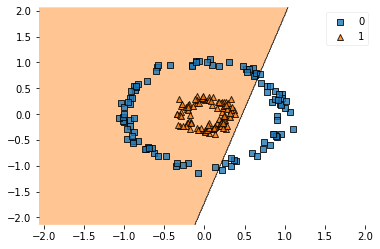

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting.decision_regions import plot_decision_regions
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def linear_kernel(x1, x2):
    return x1.T @ x2

def poly_kernel(x1,x2,d=2):
  return (1.0 + x1.dot(x2.T)) ** d
class svm():
    def __init__(self, kernel='linear', c=1.0, tol=1e-3, maxiter=10,d=3):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter
        self.d=d
        if self._kernel == 'linear':
            self._k = linear_kernel
        elif self._kernel=='poly':
          self._k=poly_kernel
        
        self._c = c
        
    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0
        self.ones = np.ones(self._data.shape[0])
        if self._kernel == 'linear':
            self._weights = np.random.rand(self._data.shape[1])
        elif self._kernel=='poly':
            pass
            #self._weights = np.random.rand(self._data.shape[1])

    def _decision_function(self, X):
        return (self.alpha * self.y).dot(self._k(self.X, X)) + self.b
    def predict_score(self, x):
        """Predicts a raw score (not classification)
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        u = 0
        if self._kernel == 'linear':
            u = self._weights @ x.T - self._b
        else:
            u += np.sign(self._decision_function(x))
        return u
        
    def predict(self, x):
        """Classifies input samples.
        
        Arguments
        x, array (batch_size, n_features) - input samples.
        """
        score = self.predict_score(x)

        if type(score) is np.ndarray:
          score[score < 0] = -1
          score[score >= 0] = 1

          return score
        else:
           return -1 if score < 0 else 1
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)
    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0

        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]

        # Compute errors for x1 and x2
        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2

        s = y1 * y2

        if s == 1:
            L = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)

        if L == H:
            return 0
        
        k11 = self._k(x1, x1)
        k22 = self._k(x2, x2)
        k12 = self._k(x1, x2)
        #print(k11)
        eta = k11 + k22 - 2 * k12
        #Tested the negative eta initially
        #eta=-2

        if eta > 0:
            a2 = alpha2 + y2 * (e1 - e2) / eta
            if a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
        elif eta<0:
          L1=alpha1+(s*(alpha2-L))
          H1=alpha1+(s*(alpha2-H))
          F1=(y1*(e1+self._b))-(alpha1*k11)-(s*alpha2*k12)
          F2=(y2*(e2+self._b))-(s*(alpha1*k12))-(alpha2*k22)
          Lobj=(L1*F1)+(L*F2)+(0.5*(L1**2)*k11)+(0.5*(L**2)*k22)+(s*L*L1*k12)
          Hobj=(H1*F1)+(H*F2)+(0.5*(H1**2)*k11)+(0.5*(H**2)*k22)+(s*H*H1*k12)
          if(Lobj<(Hobj-1e-3)):
            a2=L
          elif(Lobj>(Hobj+1e-3)):
            a2=H
          else:
            a2=alpha2
        else:
            print(f"[DEBUG] smo_step: eta = {eta}")
            
        if np.abs(a2 - alpha2) < 1e-3 * (a2 + alpha2 + 1e-3):
            return 0

        a1 = alpha1 + s * (alpha2 - a2)

        # Update threshold to reflect change in Lagrange multipliers
        b1 = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2 = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1 + b2) / 2

        # Update weight vector to reflect change in a1 & a2, if SVM is linear
        if self._kernel == 'linear':
            self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)
        
        # Store a1 and a2 in alpha array
        self._alphas[i1] = a1
        self._alphas[i2] = a2

        # update error cache using new multipliers
        for i in range (self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]

        return 1

    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        r2 = e2 * y2

        # Heuristic for picking the first multiplier
        if (r2 < -self._tol and alpha2 < self._c) or (r2 > self._tol and alpha2 > 0):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]

            if len(f_idxs) > 1:
                # Hueristic for second multiplier: get i1 with lowest absolute error |e1 - e2|

                # TODO: Clean this up
                if e2 > 0:
                    min_error = 999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error < min_error:
                            min_error = error
                            i1 = v
                else:
                    max_error = -999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error > max_error:
                            max_error = error
                            i1 = v

                if self.smo_step(i1, i2):
                    return 1
                
                # Loop over all non-zero and non-C alpha, starting at random point
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1
                
                # Loop over all possible i1, starting at a random point
                for i in range(self._data.shape[0]):
                    if i == i2:
                        continue
                    if self.smo_step(i, i2):
                        return 1
                
        return 0
    def linearfit(self,data,targets):
        self._data = data
        self._targets = targets
        
        self._init_params()
        
        n_changed = 0
        examine_all = True
        n_iter = 0
        
        while (n_changed > 0 or examine_all is True) and n_iter < self._maxiter:
            n_changed = 0
            n_iter += 1
            
            if examine_all is True:
                # loop over all training examples
                for i in range(data.shape[0]):
                    n_changed += self.examine(i)
            else:
                # loop over examples where alpha is not 0 & not C
                f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                for i, v in enumerate(f_idxs):
                    n_changed += self.examine(v)
            
            if examine_all is True:
                examine_all = False
            elif n_changed == 0:
                examine_all = True
    def polyfit(self,X, y, lr=1e-3, epochs=500):
          self._data = X
          self._targets = y
          self.X = X
          self.y = y
          self._init_params()
          # (500,)
          self.alpha = np.random.random(X.shape[0])


          # (500,500) =      (500,500) *        (500,500)
          y_iy_jk_ij = np.outer(y, y) * self._k(X, X)

          losses = []
          for _ in range(epochs):
              # (500,)  =    (500,)      (500,500).(500,)=(500,)
              gradient = self.ones - y_iy_jk_ij.dot(self.alpha)
              # Same code
              # gradient = self.ones - np.sum(y_iy_jk_ij * self.alpha)

              self.alpha = self.alpha + lr * gradient

              self.alpha[self.alpha > self._c] = self._c
              self.alpha[self.alpha < 0] = 0

              #                                        (500,500)                            (500,500)
              loss = np.sum(self.alpha) - 0.5 * np.sum(np.outer(self.alpha, self.alpha) * y_iy_jk_ij)
              losses.append(loss)

          index = np.where((self.alpha) > 0 & (self.alpha < self._c))[0]
          # (m,)= (m,)       (n,).(n,m)= (m,)
          b_i = y[index] - (self.alpha * y).dot(self._k(X, X[index]))
          # Alternative code
          # b_i = y[index] - np.sum((self.alpha * y).reshape(-1, 1)*self.kernel(X, X[index]), axis=0)
          self.b = np.mean(b_i)

          plt.plot(losses)
          plt.title("loss per epochs")
          plt.show()
    def fit(self, data, targets):
          if self._kernel == 'linear':
            self.linearfit(data,targets)
          elif self._kernel=='poly':
            self.polyfit(data,targets)
        
    def plot_decision_boundary(self):
          plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, s=50, cmap=plt.cm.Paired, alpha=.5)
          ax = plt.gca()
          xlim = ax.get_xlim()
          ylim = ax.get_ylim()

          # create grid to evaluate model
          xx = np.linspace(xlim[0], xlim[1], 30)
          yy = np.linspace(ylim[0], ylim[1], 30)
          YY, XX = np.meshgrid(yy, xx)
          xy = np.vstack([XX.ravel(), YY.ravel()]).T
          Z = self._decision_function(xy).reshape(XX.shape)

          # plot decision boundary and margins
          ax.contour(XX, YY, Z, colors=['b', 'g', 'r'], levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'], linewidths=[2.0, 2.0, 2.0])

          # highlight the support vectors
          ax.scatter(self.X[:, 0][self.alpha > 0.], self.X[:, 1][self.alpha > 0.], s=50,
                      linewidth=1, facecolors='none', edgecolors='k')

          plt.show()          

#n_a_samples = 50
#n_b_samples = 50
#a_samples = np.random.multivariate_normal([-1, 1], [[0.1, 0], [0, 0.1]], n_a_samples)
#b_samples = np.random.multivariate_normal([1, -1], [[0.1, 0], [0, 0.1]], n_b_samples)
#a_targets = np.ones(n_a_samples) * -1  # Samples from class A are assigned a class value of -1.
#b_targets = np.ones(n_b_samples)  # Samples from class B are assigned a class value of 1.

X, y = make_circles(n_samples=2000, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,stratify=y, random_state=0)

#samples = np.concatenate((a_samples, b_samples))
#targets = np.concatenate((a_targets, b_targets))
#print(samples.shape, targets.shape)
model = svm(c=5.0)
model.fit(X_train,y_train)
#print(model._weights)
#print(model._b)
# for i in range(samples.shape[0]):
#     print(f"Sample {i}: score={model.predict_score(samples[i])}, alpha={model._alphas[i]}")


print(f"weights={model._weights}")
print(f"b={model._b}")

fig = plt.figure()
ax = plot_decision_regions(X_test,y_test.astype(np.int32), model)
fig.add_subplot(ax)
plt.show()


coef_=[[ 0.11332549 -0.11086333]]
intercept=[-5.29379283e-05]


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


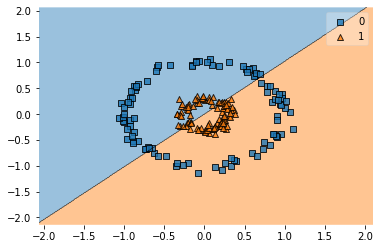

In [ ]:
from sklearn.svm import LinearSVC
sk_model = LinearSVC()
sk_model.fit(X_test,y_test.astype(np.int32))

print(f"coef_={sk_model.coef_}")
print(f"intercept={sk_model.intercept_}")

fig = plt.figure()
ax = plot_decision_regions(X_test,y_test.astype(np.int32), sk_model)
fig.add_subplot(ax)
plt.show()


In [ ]:

# def feature_transform(x):
#   return np.vstack((x[:, 0]**2, x[:, 1]**2, np.sqrt(2) * x[:, 0] * x[:, 1])).T

# X, y = make_circles(n_samples=100, factor=0.3, noise=0.05, random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,stratify=y, random_state=0)
# X_train_k = feature_transform(X_train)
# X_test_k = feature_transform(X_test)

# _, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4), subplot_kw=dict(projection='3d'))

# train_ax.scatter(X_train_k[:, 0], X_train_k[:, 1], X_train_k[:, 2], c=y_train)
# train_ax.set_ylabel("Feature #1")
# train_ax.set_xlabel("Feature #0")
# train_ax.set_title("Training data")

# test_ax.scatter(X_test_k[:, 0], X_test_k[:, 1], c=y_test)
# test_ax.set_xlabel("Feature #0")
# _ = test_ax.set_title("Testing data")

# model_nonlinear = svm(kernel='poly',c=5.0)
# model_nonlinear.fit(X_train,y_train)
# print(X_train.shape)


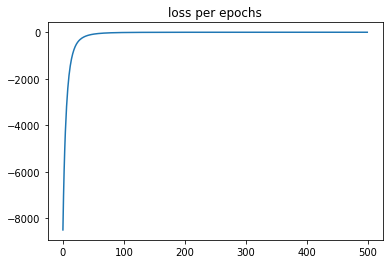

train score: 1.0


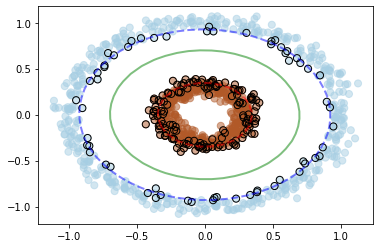

In [ ]:
X, y = make_circles(n_samples=1000, factor=0.3, noise=0.05, random_state=0)
y[y == 0] = -1

svm_poly_model = svm(kernel='poly',c=1.0)
svm_poly_model.fit(X, y)
print("train score:", svm_poly_model.score(X, y))
svm_poly_model.plot_decision_boundary()
